In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from datetime import date, timedelta

import numpy as np
import pandas as pd
import jax.numpy as jnp

import mechafil.data as mecha_data
import mechafil.sim as np_sim

import mechafil_jax.data as data
import mechafil_jax.sim as sim
import mechafil_jax.constants as C
import mechafil_jax.minting as minting
import mechafil_jax.plot_utils as pu

import scenario_generator.utils as u
import scenario_generator.curated as curated

In [3]:
save_dir = '/Users/kiran/Documents/baseline_project'
os.makedirs(save_dir, exist_ok=True)

In [4]:
token = '/Users/kiran/code/filecoin-mecha-twin/kiran_spacescope_auth.json'

start_date = date(2023, 7, 1)
current_date = date.today() - timedelta(days=3)
forecast_length = 365*10
end_date = current_date + timedelta(days=forecast_length)

offline_data = data.get_simulation_data(token, start_date, current_date, end_date)

print(start_date, current_date, end_date)

2023-07-01 2023-07-21 2033-07-18


In [5]:
# baseline = minting.compute_baseline_power_array(
#     np.datetime64(start_date), np.datetime64(end_date), offline_data['init_baseline_eib'],
# )

In [6]:
# get historical RBP, RR, FPR for last 180 days to setup simulation trajectories
t_hist_rbp, hist_rbp = u.get_historical_daily_onboarded_power(current_date-timedelta(days=180), current_date)
t_hist_rr, hist_rr = u.get_historical_renewal_rate(current_date-timedelta(days=180), current_date)
t_hist_fpr, hist_fpr = u.get_historical_filplus_rate(current_date-timedelta(days=180), current_date)

smoothed_last_historical_rbp = np.median(hist_rbp[-30:])
smoothed_last_historical_rr = np.median(hist_rr[-30:])
smoothed_last_historical_fpr = np.median(hist_fpr[-30:])

print(smoothed_last_historical_rbp, smoothed_last_historical_rr, smoothed_last_historical_fpr)

6.0076751708984375 0.7111087799023373 0.8977328905886782


<IPython.core.display.Javascript object>


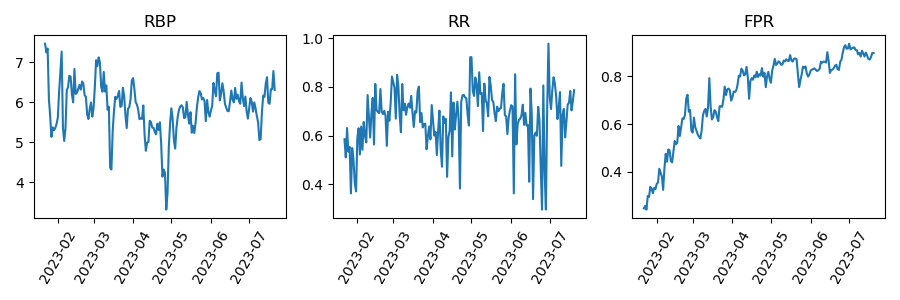

In [7]:
plt.figure(figsize=(9,3))
plt.subplot(1,3,1)
plt.plot(t_hist_rbp, hist_rbp)
plt.xticks(rotation=60)
plt.title('RBP')

plt.subplot(1,3,2)
plt.plot(t_hist_rr, hist_rr)
plt.xticks(rotation=60)
plt.title('RR')

plt.subplot(1,3,3)
plt.plot(t_hist_fpr, hist_fpr)
plt.xticks(rotation=60)
plt.title('FPR')

plt.tight_layout()

In [8]:
lock_target = 0.3
sector_duration=540

In [9]:
np.log(2)/(365)*.95

0.0018040817028272549

In [10]:
# create scenarios
g = np.log(2)/(365)
constant_scenarios = {
    '0.25x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*.25,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '0.5x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*.5,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '1x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '2x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*2,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '5x': {
        'rbp': np.ones(forecast_length) * smoothed_last_historical_rbp*5,
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    }
    
}
linear_scenarios = {
    '0.25x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp*0.25 + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '0.5x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp*0.5 + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '1x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '2x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp*2 + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '5x': {
        'rbp': np.arange(forecast_length)/365.0 * smoothed_last_historical_rbp*5 + offline_data['init_baseline_eib'],
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
}
exponential_scenarios = {
    '2x': {
        'rbp': smoothed_last_historical_rbp*np.exp(g*np.arange(forecast_length)) + (offline_data['init_baseline_eib']-smoothed_last_historical_rbp),
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '1.5x': {
        'rbp': smoothed_last_historical_rbp*np.exp((g*0.59)*np.arange(forecast_length)) + (offline_data['init_baseline_eib']-smoothed_last_historical_rbp),
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    },
    '2.5x': {
        'rbp': smoothed_last_historical_rbp*np.exp((g*1.325)*np.arange(forecast_length)) + (offline_data['init_baseline_eib']-smoothed_last_historical_rbp),
        'rr': np.ones(forecast_length) * smoothed_last_historical_rr,
        'fpr': np.ones(forecast_length) * smoothed_last_historical_fpr
    }
}

colors = [mpl.colormaps['Blues'], mpl.colormaps['Oranges'], mpl.colormaps['Greens'], mpl.colormaps['Purples'], mpl.colormaps['Reds']]

In [11]:
g = np.log(2)/365;  v1 = np.exp(g*365); v2 = np.exp(g*365*2); print(v2/v1)
g = 0.59*np.log(2)/365;  v1 = np.exp(g*365); v2 = np.exp(g*365*2); print(v2/v1)
g = 1.325*np.log(2)/365;  v1 = np.exp(g*365); v2 = np.exp(g*365*2); print(v2/v1)

2.0
1.5052467474110671
2.5053288772482554


<IPython.core.display.Javascript object>


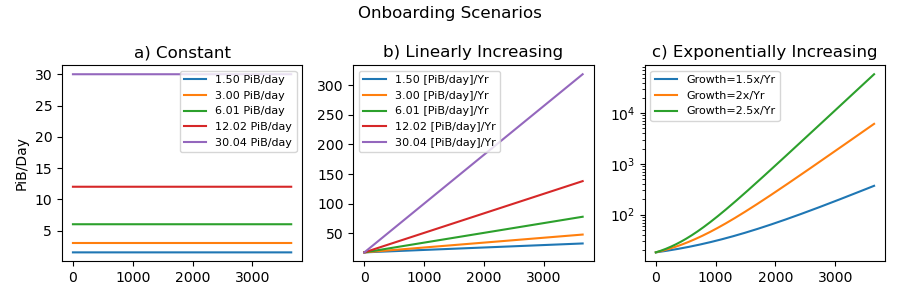

In [12]:
# plot the RBP trajectories for comparison
plt.figure(figsize=(9,3))

plt.subplot(1,3,1)
# plt.plot(baseline, linestyle=':', color='k', label='Baseline')
constant_labels = [
    '%0.02f PiB/day' % (np.mean(constant_scenarios['0.25x']['rbp']),),
    '%0.02f PiB/day' % (np.mean(constant_scenarios['0.5x']['rbp']),),
    '%0.02f PiB/day' % (np.mean(constant_scenarios['1x']['rbp']),),
    '%0.02f PiB/day' % (np.mean(constant_scenarios['2x']['rbp']),),
    '%0.02f PiB/day' % (np.mean(constant_scenarios['5x']['rbp']),)
]
plt.plot(constant_scenarios['0.25x']['rbp'], label=constant_labels[0])
plt.plot(constant_scenarios['0.5x']['rbp'], label=constant_labels[1])
plt.plot(constant_scenarios['1x']['rbp'], label=constant_labels[2])
plt.plot(constant_scenarios['2x']['rbp'], label=constant_labels[3])
plt.plot(constant_scenarios['5x']['rbp'], label=constant_labels[4])
plt.legend(fontsize=8)
# plt.yscale('log')
plt.title('a) Constant')
plt.ylabel('PiB/Day')

plt.subplot(1,3,2)
linear_labels = [
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['0.25x']['rbp'])*365,)),
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['0.5x']['rbp'])*365,)),
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['1x']['rbp'])*365,)),
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['2x']['rbp'])*365,)),
    '%0.02f [PiB/day]/Yr' % (np.mean(np.diff(linear_scenarios['5x']['rbp'])*365,))
]
# plt.plot(baseline, linestyle=':', color='k', label='Baseline')
plt.plot(linear_scenarios['0.25x']['rbp'], label=linear_labels[0])
plt.plot(linear_scenarios['0.5x']['rbp'], label=linear_labels[1])
plt.plot(linear_scenarios['1x']['rbp'], label=linear_labels[2])
plt.plot(linear_scenarios['2x']['rbp'], label=linear_labels[3])
plt.plot(linear_scenarios['5x']['rbp'], label=linear_labels[4])
plt.legend(fontsize=8)
# plt.yscale('log')
plt.title('b) Linearly Increasing')

plt.subplot(1,3,3)
# plt.plot(baseline, linestyle=':', color='k', label='Baseline')
exp_labels = [
    'Growth=1.5x/Yr',
    'Growth=2x/Yr',
    'Growth=2.5x/Yr'
]
plt.plot(exponential_scenarios['1.5x']['rbp'], label=exp_labels[0])
plt.plot(exponential_scenarios['2x']['rbp'], label=exp_labels[1])
plt.plot(exponential_scenarios['2.5x']['rbp'], label=exp_labels[2])
plt.legend(fontsize=8)
plt.yscale('log')
plt.title('c) Exponentially Increasing')

plt.suptitle('Onboarding Scenarios')

plt.tight_layout()

plt.savefig(os.path.join(save_dir, 'rbp_trajectories.png'))

In [13]:
# # add ROI to trajectory
# def to_np64(x):
#     return np.asarray(x, dtype=np.float64)

# def add_generated_quantities(results_dict:dict)->dict:
#     # add ROI to trajectory df
#     days_1y = 365
    
#     results_dict['day_pledge_per_QAP'] = C.SECTOR_SIZE * (to_np64(results_dict['day_locked_pledge'])-to_np64(results_dict['day_renewed_pledge']))/(to_np64(results_dict['day_onboarded_power_QAP_PIB'])*C.PIB)
#     results_dict['day_rewards_per_sector'] = C.SECTOR_SIZE * to_np64(results_dict['day_network_reward']) / (to_np64(results_dict['network_QAP_EIB'])*C.EIB)
    
#     rps = np.convolve(results_dict['day_rewards_per_sector'], np.ones(days_1y), mode='full')
#     results_dict['1y_return_per_sector'] = rps[days_1y-1:1-days_1y]
#     results_dict['1y_sector_roi'] = results_dict['1y_return_per_sector'] / results_dict['day_pledge_per_QAP'][:1-days_1y]
    
#     return results_dict

In [14]:
# run JAX simulation
scenario_vector = [
    ('constant', constant_scenarios),
    ('linear', linear_scenarios),
    ('exponential', exponential_scenarios),
]
scenario_results = {}

for n, scenario_dict in scenario_vector:
    sweep_results = {}
    for scenario_name, trajectories in scenario_dict.items():

        rbp = jnp.array(trajectories['rbp'])
        rr = jnp.array(trajectories['rr'])
        fpr = jnp.array(trajectories['fpr'])

        simulation_results = sim.run_sim(
            rbp,
            rr,
            fpr,
            lock_target,

            start_date,
            current_date,
            forecast_length,
            sector_duration,
            offline_data
        )
#         with_roi = add_generated_quantities(simulation_results)

        sweep_results[scenario_name] = simulation_results
    scenario_results[n] = sweep_results

# total_sim_len = (end_date - start_date).days
# t = [start_date + timedelta(days=i) for i in range(total_sim_len)]

In [20]:
def plot_scenario_results(key='constant', plot_baseline=True, log_scale_power=True, labels=None):
    scenario2results = scenario_results[key]
    keys = list(scenario2results.keys())
    if labels is None:
        labels = list(scenario2results.keys())
    c_vec = [c(0.6) for c in colors]
    
    suptitle_str = '%s Onboarding Scenarios' % (key.upper(),)
    output_fp = os.path.join(save_dir, '%s_locked_trajectories_pu.png' % (key,))
    
    fig, ax = pu.plot_kpi_panel(
        start_date,
        end_date,
        scenario2results, 
        init_baseline_eib = offline_data['init_baseline_eib'],
        figsize=(8,10),  
        color_vec=c_vec, 
        suptitle_str=suptitle_str,
        labels_vec=labels,
        log_scale_power=log_scale_power,
    )
    
    if not log_scale_power:
        axx = ax[0,1]
        if key == 'constant':
            axx.set_ylim(10,400)
        elif key == 'linear':
            axx.set_ylim(10,4000)
            
    fig.savefig(output_fp)

2023-07-01 3670


<IPython.core.display.Javascript object>


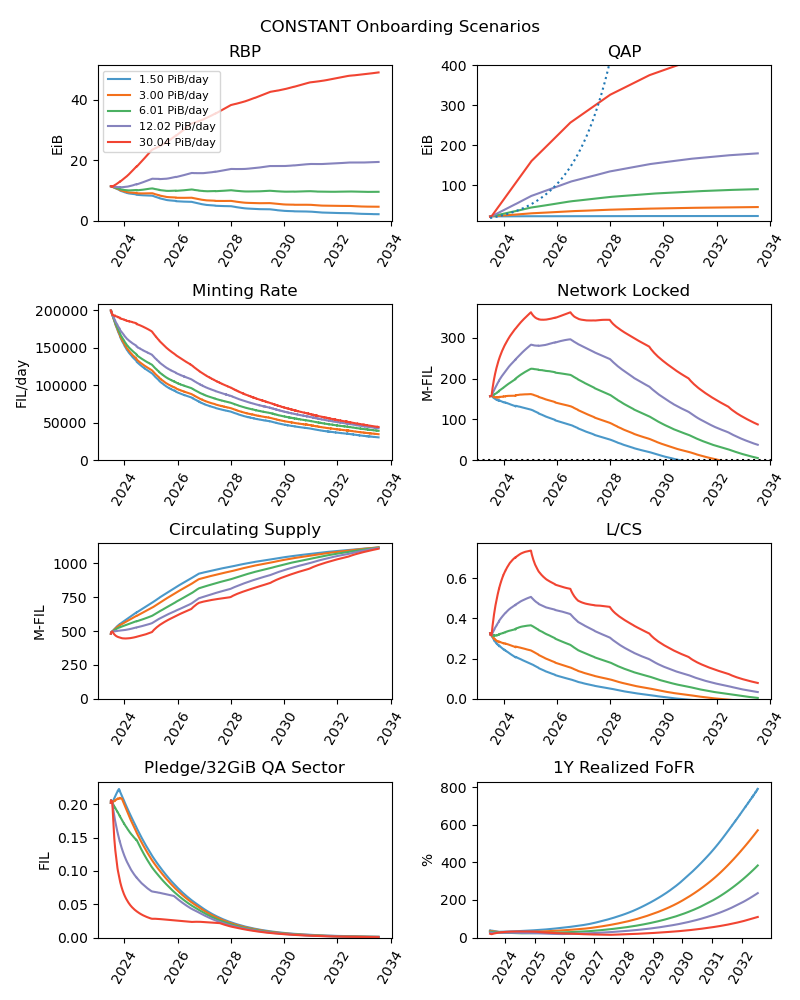

In [21]:
plot_scenario_results(key='constant', plot_baseline=True, log_scale_power=False, labels=constant_labels)

2023-07-01 3670


<IPython.core.display.Javascript object>


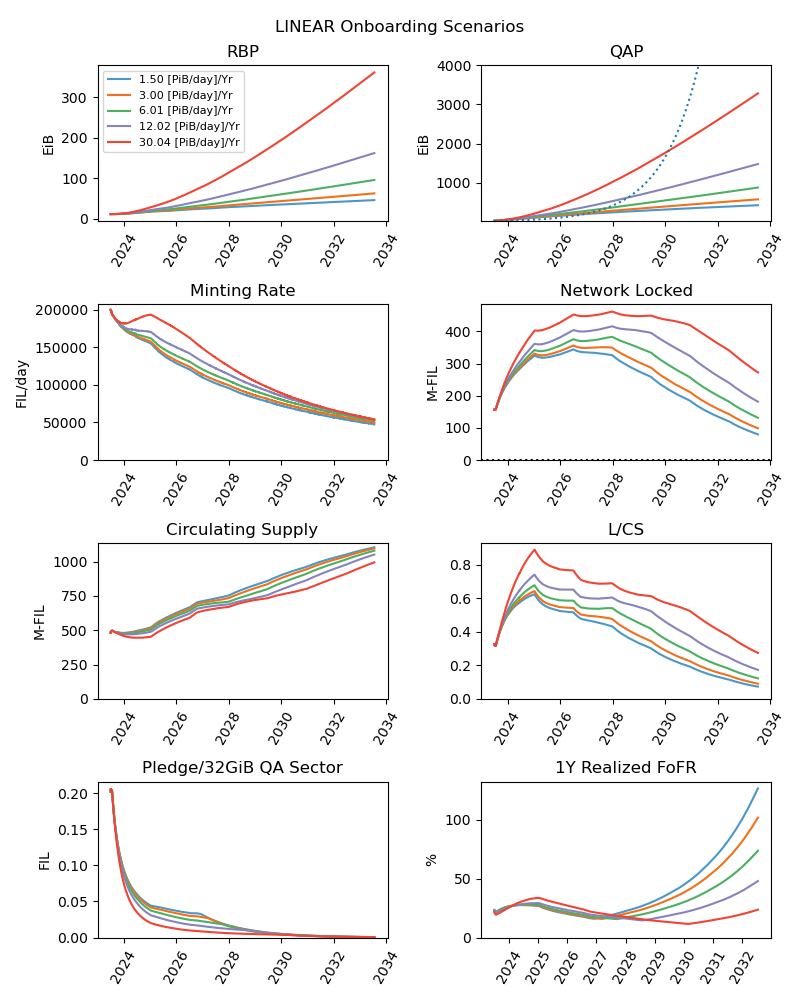

In [22]:
plot_scenario_results(key='linear', plot_baseline=True, log_scale_power=False, labels=linear_labels)

2023-07-01 3670


<IPython.core.display.Javascript object>


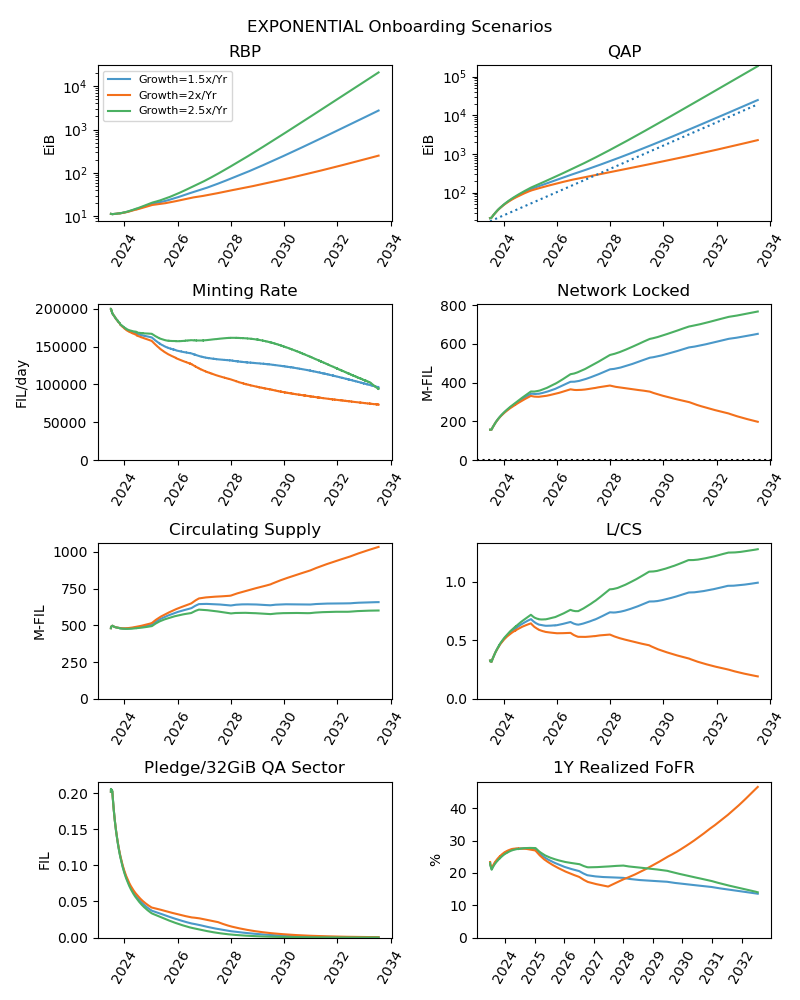

/Users/kiran/code/mechafil-jax/mechafil_jax/plot_utils.py:43: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axx.set_ylim(0)
/Users/kiran/code/mechafil-jax/mechafil_jax/plot_utils.py:57: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  axx.set_ylim(0)


In [23]:
plot_scenario_results(key='exponential', log_scale_power=True, labels=exp_labels)